In [1]:
#버전       V_0.01 
#작성자     최연석
#분류       subQ4
#목표1      얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였다.
#목표2      정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.
#목표3      얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.
#수정사항   write 1st edit(2023.07.12)


import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 


FILE_PATH = "./" #local
#FILE_PATH = "~/data/data/" #lms
FILE_NAME_FACE = "ys.jpg"
FILE_NAME_EDITFACE = "edit_ys.jpg"
FILE_NAME_WHISKERS = "cat_whiskers.png"
FILE_NAME_DLIBMODEL = "shape_predictor_68_face_landmarks.dat"


#이미지 read
def read_file(file_path, file_name_face, file_name_whiskers):
    return cv2.imread(file_path + file_name_face, 1), cv2.imread(file_path + file_name_whiskers, 1)


#img bgrtorgb convert
def show_img_bgrtorgb(img):
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB) 
    plt.show()


# 얼굴 위치 좌표 표시
def chk_face_rect(dlib_rects, img_face):
    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽

        cv2.rectangle(img_face, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림


#얼굴 포인트 좌표 표시
def print_face_landmark(dlib_rects, landmark_predictor, img_face_origin):
    list_landmarks = []
     
    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_face_origin, dlib_rect) #노이즈 없는 원본 이미지 사용
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    return list_landmarks


def print_face_landmarkPoint(list_landmarks, img_face):
    # list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_face, point, 10, (0, 255, 255), -1) #표시할 이미지 선택
                # cv2.circle: OpenCV의 원을 그리는 함수
                # img_show 이미지 위 각각의 point에
                # 크기가 10이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
                # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)


# 코의 센터값과 얼굴 인식 width, height값 추출
def get_local_nose(dlib_rects, list_landmarks):
    # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks): 
        print (landmark[30]) # 코의 index는 30 입니다
        x = landmark[30][0] # 이미지에서 코 부위의 x값
        y = landmark[30][1] # 이미지에서 코 부위의 y값
        w = h = dlib_rect.width() 
        print (f'(x,y) : ({x},{y})')
        print (f'(w,h) : ({w},{h})')

    return x, y, w, h


# 이미지가 작아 음수 발생 시: 이미지 범위를 벗어날때 스티커 crop, refined_x, refined_y를 0 으로 보정
def calib_out_sticker(refined_x, refined_y, img_whiskers_origin):
    if refined_x < 0: 
        img_whiskers_origin = img_whiskers_origin[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_whiskers_origin = img_whiskers_origin[-refined_y:, :] 
        refined_y = 0

    print (f'(x,y) : ({refined_x},{refined_y})')

    return refined_x, refined_y, img_whiskers_origin


In [5]:
# 1. 이미지 호출
try:
    #img read       
    img_face_origin, img_whiskers_origin = read_file(FILE_PATH, FILE_NAME_FACE, FILE_NAME_WHISKERS)

except:
    print("Error : failed to read image")

In [6]:
# 포인트를 찾기위한 이미지 복사본 생성
img_face = img_face_origin.copy()

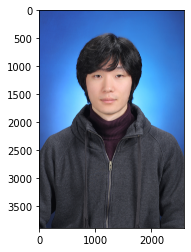

In [7]:
# 이미지 컬러 변경(RGB)
show_img_bgrtorgb(img_face)

In [8]:
# 이미지 사이즈 확인
print("face : " + str(img_face.shape))

face : (3888, 2592, 3)


In [9]:
# 2. dlib api를 사용하여 얼굴 인식
#detector
detector_hog = dlib.get_frontal_face_detector()

In [10]:
# upsampling, 얼굴 위치 찾기
dlib_rects = detector_hog(img_face_origin, 1) #sec param : num of image pyramid
print(dlib_rects) 

rectangles[[(869, 1047) (1668, 1845)]]


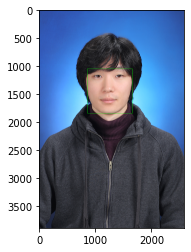

In [12]:
# 얼굴 위치 좌표 표시
chk_face_rect(dlib_rects, img_face)

show_img_bgrtorgb(img_face)

In [13]:
# 3. dlib api를 사용하여 얼굴 포인트 인식
# dlib에서 제공해주는 모델 사용
try:
    #dlib model load       
    landmark_predictor = dlib.shape_predictor(FILE_PATH + FILE_NAME_DLIBMODEL)

except:
    print("Error : failed to dlib model load")

In [14]:
#얼굴 포인트 좌표 표시
list_landmarks = print_face_landmark(dlib_rects, landmark_predictor, img_face_origin)
print(len(list_landmarks[0]))

68


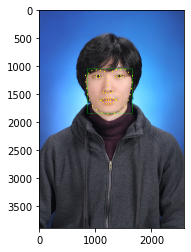

In [15]:
#얼굴 포인트 좌표 그리기
print_face_landmarkPoint(list_landmarks, img_face)

show_img_bgrtorgb(img_face)

In [16]:
# 코의 센터값과 얼굴 인식 width, height값 추출
x, y, w, h = get_local_nose(dlib_rects, list_landmarks)

(1229, 1408)
(x,y) : (1229,1408)
(w,h) : (800,800)


In [17]:
# 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
img_whiskers_origin = cv2.resize(img_whiskers_origin, (w,h)) 
print (img_whiskers_origin.shape) 

(800, 800, 3)


In [18]:
refined_x = x - w // 2 
refined_y = y - h // 2
print (f'(x,y) : ({refined_x},{refined_y})') 

(x,y) : (829,1008)


In [19]:
# 이미지가 작아 음수 발생 시: 이미지 범위를 벗어날때 스티커 crop, refined_x, refined_y를 0 으로 보정
refined_x, refined_y, img_whiskers_origin = calib_out_sticker(refined_x, refined_y, img_whiskers_origin)

(x,y) : (829,1008)


In [20]:
# 얼굴이미지에서 스티커 이미지가 위치를 crop
sticker_area = img_face[refined_y:refined_y+img_whiskers_origin.shape[0], refined_x:refined_x+img_whiskers_origin.shape[1]]

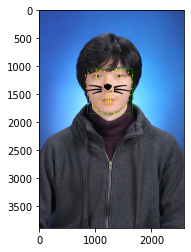

In [22]:
# 얼굴 이미지에 적용
img_face[refined_y:refined_y+img_whiskers_origin.shape[0], refined_x:refined_x+img_whiskers_origin.shape[1]] = \
    np.where(img_whiskers_origin==255,sticker_area,img_whiskers_origin).astype(np.uint8)
show_img_bgrtorgb(img_face)

In [23]:
# 원본 얼굴이미지에서 스티커 이미지가 위치를 crop
sticker_area = img_face_origin[refined_y:refined_y +img_whiskers_origin.shape[0], refined_x:refined_x+img_whiskers_origin.shape[1]]

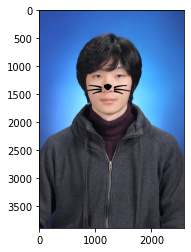

In [25]:
# 원본 얼굴 이미지에 적용
img_face_origin[refined_y:refined_y +img_whiskers_origin.shape[0], refined_x:refined_x+img_whiskers_origin.shape[1]] = \
    np.where(img_whiskers_origin==255,sticker_area,img_whiskers_origin).astype(np.uint8)
show_img_bgrtorgb(img_face_origin)

In [26]:
try:
    #수정된 이미지 저장  
    cv2.imwrite(FILE_PATH + FILE_NAME_EDITFACE, img_face_origin)

except:
    print("Error : failed to img save")

In [27]:
print("종료")

종료
